In [1]:
import numpy as np

import itertools

import matplotlib.pyplot as plt
from matplotlib import colors

from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from scipy import ndimage


# Extract Boundary

In [2]:
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt

def extract_ordered_boundary(mask, return_countor: bool=False):
    """
    Exclude the ordered boundary as list of tuples 

    Parameters:
    -----------
    mask: np.array ndim=2
        The binary mask
    
    return_countor: bool:
        Returns the float coordinates between pixels if True
        Returns the coordinates of the pixesl if False

    Returns:
    --------
    ordered_boundary: list[tuple]
        coordinates of the boundary
    """
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        raise ValueError("Could not find a border")
    
    # Take the longest border if there are many
    contour = max(contours, key=len)
    if return_countor:
        return contour

    # Choose the border pixels
    ordered_boundary = [(int(round(y)), int(round(x))) for y, x in contour]
    ordered_boundary = [(y, x) for y, x in contour]
    ordered_boundary = []
    for y, x, in contour:
        if y%1 == 0:
            y, x = int(y), int(x)
            if not mask[y, x]:
                x += 1
        else:
            y, x = int(y), int(x)
            if not mask[y, x]:
                y += 1
        if (y, x) not in ordered_boundary:
            ordered_boundary.append((y, x))
    

    return ordered_boundary


# Complex Way
We need to define a continuous $f: \mathbb{C}\to\mathbb{C}$ such that $$
1. for number $z_0\in\mathbb{C}$ 
    $$
        f(z_0) = 0
    $$
2. for $n$ points $z_1, z_2, ..., z_n\in\mathbb{C}$ and $\phi_1, \phi_2, ..., \phi_n\in [0, 2\pi)$ ($\phi_1 < \phi_2 < ... < \phi_n$)
    $$
        f(z_k) = e^{i\phi_k}
    $$
    moreover for $t\in[0, 1]$
    $$
        f((1 - t)\cdot z_k + t\cdot z_{k+1}) = e^{i((1 - t)\cdot\phi_k + t\phi_{k+1})}
    $$
    where $z_{n+1} := z_1$ and $\phi_{n+1}:= \phi_1 + 2\pi$.

We also garantee, that the partially linear closed curve $z_1, z_2, ..., z_n, z_{n+1}$ does not intersect itself. We should get the bijection from the area inside this curve to a unit disk.

## Border Map

Let's first focus on the second condition, and we will just build a map $f_1:\mathbb{C} \to \mathbb{C}$ such that for $n$ points $z_1, z_2, ..., z_n\in\mathbb{C}$ and $\phi_1, \phi_2, ..., \phi_n\in [0, 2\pi)$ ($\phi_1 < \phi_2 < ... < \phi_n$) and $z_{n+1} := z_1$ and $\phi_{n+1}:= \phi_1 + 2\pi$ the following will be true:
$$
    f((1 - t)\cdot z_k + t\cdot z_{k+1}) = e^{i((1 - t)\cdot\phi_k + t\phi_{k+1})}
$$

We can build a triangulation on the set of points $z_1, ..., z_n$ and then we will map each triangle to a segment of the unit disk:



In [3]:
from scipy.spatial import Delaunay

import triangle

In [4]:
def triangulate_complex_numbers(zs, fix_perimeter=True):
    """
    """
    points = np.transpose([np.real(zs), np.imag(zs)])
    if not fix_perimeter:
        tri = Delaunay(points)
        return tri.simplices
    segments = np.transpose([np.arange(len(zs)), (np.arange(len(zs)) + 1)%len(zs)])
    tri = triangle.triangulate(dict(vertices=points, segments=segments), "p")
    assert (tri['vertices'] == points).all()
    return tri['triangles']


### Represent Complex Number in the Triangle
The point $z$ is in triangle $(z_1, z_2, z_3)$ if this can be represented as
$$
    z = t_1\cdot z_1 + t_2\cdot z_2 + t_3\cdot z_3
$$
where $t_1 + t_2 + t_3 = 1$ and $t_1, t_2, t_3 > 0$.

We can find these coefficients $t_1, t_2, t_3$ feom the system:
$$
\begin{pmatrix}
1 & 1 & 1 \\
\operatorname{Re} z_1 & \operatorname{Re} z_2 & \operatorname{Re} z_3 \\
\operatorname{Im} z_1 & \operatorname{Im} z_2 & \operatorname{Im} z_3 
\end{pmatrix}
\begin{pmatrix}
t_1 \\ t_2 \\ t_3
\end{pmatrix}
=
\begin{pmatrix}
1 \\
\operatorname{Re} z \\
\operatorname{Im} z 
\end{pmatrix}
$$

In [5]:
def get_triangle_representation(z, z1, z2, z3):
    """
    Parameters:
    -----------
    z: complex array
        A complex number or an array of complex numbers to be represented in the triangle
    
    z1, z2, z3: complex numbers
        Vertices of the triangle
    
    Returns:
    --------
    t: np.array
        An array of shape (z.shape) + (3,) with coefficients for the representation of `z` in the triangle defined by `z1`, `z2`, `z3`
    """
    z = np.asarray(z)
    a1 = np.real(z2) - np.real(z1)
    b1 = np.real(z3) - np.real(z1)
    c1 = np.real(z) - np.real(z1)
    a2 = np.imag(z2) - np.imag(z1)
    b2 = np.imag(z3) - np.imag(z1)
    c2 = np.imag(z) - np.imag(z1)
    det = a1 * b2 - a2 * b1
    if np.any(det == 0):
        raise ValueError("The triangle is degenerate")
    t3 = (a1*c2 - a2*c1) / det
    t2 = (b2*c1 - b1*c2) / det
    t1 = 1 - t2 - t3
    return np.array([t1, t2, t3]).transpose(tuple(np.arange(z.ndim) + 1) + (0, ))


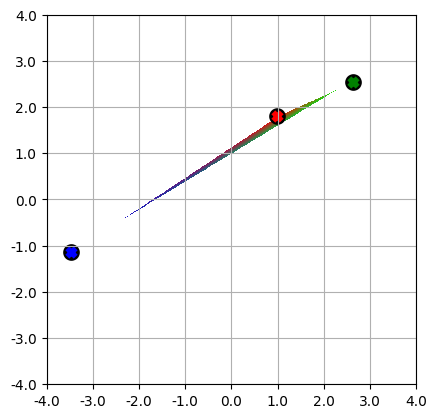

In [6]:
z1, z2, z3 = np.exp(1j*2*np.pi*(np.arange(3)/3 + 0.125))
z1, z2, z3 = 8*(np.random.random(3) + 1j*np.random.random(3)) - 4 - 4j

x = np.linspace(-4, 4, 1001)
y = np.linspace(-4, 4, 1001)
z = x.reshape(1, -1) + 1j*y.reshape(-1, 1)

m = get_triangle_representation(z, z1, z2, z3)
m[(m < 0).any(axis=-1) | (m > 1).any(axis=-1)] = np.nan  # Exclude points outside the triangle
plt.imshow(m, origin='lower')
for zi, color in zip([z1, z2, z3], 'rgb'):
    xi = np.argmin(abs(x - np.real(zi)))
    yi = np.argmin(abs(y - np.imag(zi)))
    plt.scatter(xi, yi, color='black', linewidth=6, marker='o')
    plt.scatter(xi, yi, color=color, linewidth=4,marker='x')

plt.xticks(np.linspace(0, len(x)-1, 9).astype(int), x[np.linspace(0, len(x)-1, 9).astype(int)])
plt.yticks(np.linspace(0, len(y)-1, 9).astype(int), y[np.linspace(0, len(y)-1, 9).astype(int)])
plt.grid(True)
plt.show()

### Map from Triangle to a Disk Segment

There are 3 scenarios are possible:
1. Zero edges of the triangle bocome arcs
2. One edge of the triangle becomes arc
3. Two edges of the triangle become arcs


Let's look at eac of them
1. In the first case we will simply represent $f$ this as linear function
    $$
        f(z) = f(t_1 z_1 + t_2 z_2 + t_3 z_3) = 
        t_1f(z_1) + t_2f(z_2) + t_3f(z_3) = 
        t_1e^{\phi_1} + t_2e^{\phi_2} + t_3e^{\phi_3} 
    $$
2. In the second case let's denote that the arc becomes from the edge $t\cdot z_0 + (1-t) \cdot z_1 \to e^{(1-t)\phi_0 + t\phi_1}$. Then
    $$
        f(z) = f(t_1 z_1 + t_2 z_2 + t_3 z_3) =
        t_2 e^{i\phi_2} + (t_0 + t_1) e^{i\frac{t_0\phi_0 + t_1\phi_1}{t_0 + t_1}}
    $$
3. In the third case let's again denote which 2 edges maps to the arcs:
    $$
        t\cdot z_0 + (1-t) \cdot z_1 \to e^{(1-t)\phi_0 + t\phi_1}
    $$
    $$
        t\cdot z_1 + (1-t) \cdot z_2 \to e^{(1-t)\phi_1 + t\phi_2}
    $$
    then
    $$
        f(z) = f(t_1 z_1 + t_2 z_2 + t_3 z_3) = 
        (t_0 + t_1)e^{i\frac{t_0\phi_0 + t_1\phi_1}{t_0 + t_1}} + 
        (t_1 + t_2)e^{i\frac{t_1\phi_1 + t_2\phi_2}{t_1 + t_2}}
    $$

In our case we will compute the values in the centers of pixels, taking their border as border points, so we can ignore cases 2 and 3

In [7]:
def map_triangle(z, z1_input, z2_input, z3_input, z1_output, z2_output, z3_output):
    """
    """
    t = get_triangle_representation(z, z1_input, z2_input, z3_input)
    z_res = t@np.array([z1_output, z2_output, z3_output], dtype='complex')
    return z_res

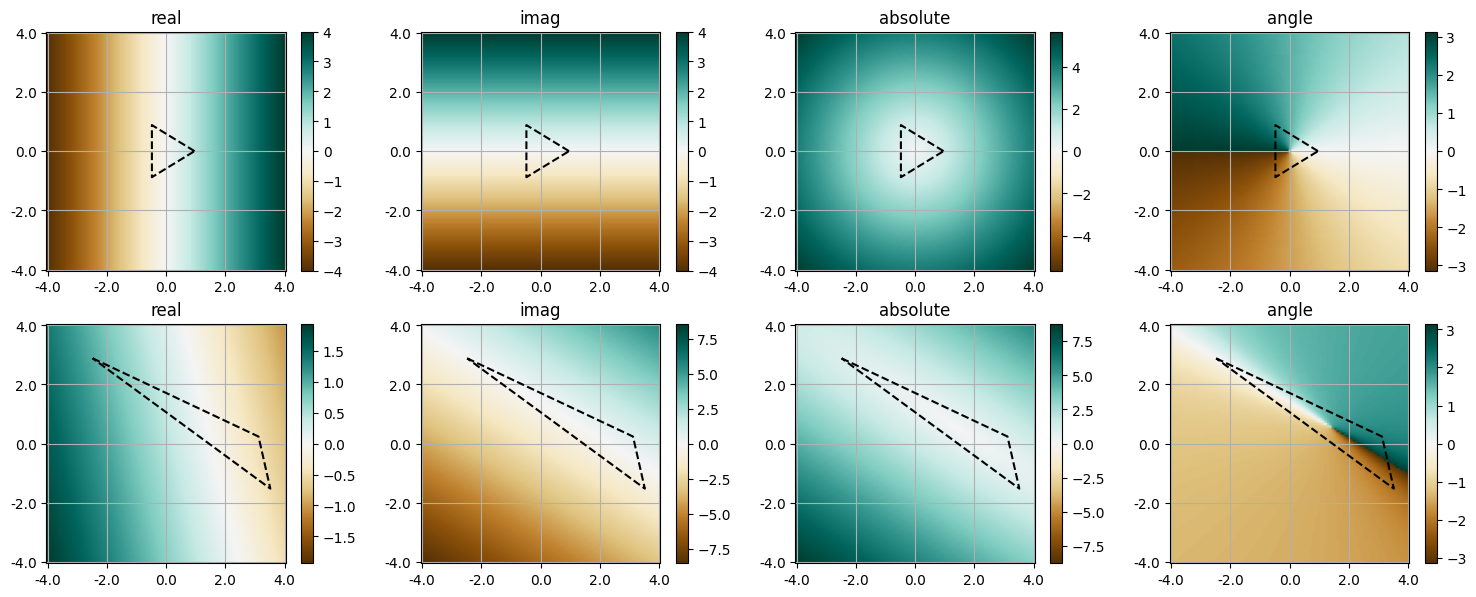

In [8]:
z1_input, z2_input, z3_input = 8*(np.random.random(3) + 1j*np.random.random(3)) - 4 - 4j
z1_output, z2_output, z3_output = np.exp(1j*2*np.pi*np.arange(3)/3)
#z1_output, z2_output, z3_output = 8*(np.random.random(3) + 1j*np.random.random(3)) - 4 - 4j

x = np.linspace(-4, 4, 101)
y = np.linspace(-4, 4, 101)
z = x.reshape(1, -1) + 1j*y.reshape(-1, 1)

z_res = map_triangle(z, z1_input, z2_input, z3_input, z1_output, z2_output, z3_output)


z_input = np.array([z1_input, z2_input, z3_input, z1_input])
x_input = [np.argmin(abs(x - np.real(zi))) for zi in z_input]
y_input = [np.argmin(abs(y - np.imag(zi))) for zi in z_input]

z_output = np.array([z1_output, z2_output, z3_output, z1_output])
x_output = [np.argmin(abs(x - np.real(zi))) for zi in z_output]
y_output = [np.argmin(abs(y - np.imag(zi))) for zi in z_output]

fig, axs = plt.subplots(2, 4, figsize=(15, 6))
for (i_col, repr), (i_row, (z, (xi, yi))) in itertools.product(enumerate([np.real, np.imag, np.abs, np.angle]), 
                                                               enumerate(zip([z, z_res], [(x_output, y_output), (x_input, y_input)]))):
    axs[i_row, i_col].set_title(f'{repr.__name__}')
    img = repr(z)
    norm = colors.TwoSlopeNorm(vmin=-abs(img).max(), vcenter=0, vmax=abs(img).max())
    cmap = plt.get_cmap('BrBG').copy()
    cmap.set_bad(color='gray')
    sm = axs[i_row, i_col].imshow(img, cmap=cmap, norm=norm, origin='lower')
    plt.colorbar(sm, ax=axs[i_row, i_col])

    axs[i_row, i_col].plot(xi, yi, color='black', linestyle='--')
    #axs[i_row, i_col].plot(x_input, y_input, color='lime', linestyle='--')
    #axs[i_row, i_col].plot(x_output, y_output, color='red', linestyle='--')
    axs[i_row, i_col].set_xticks(np.linspace(0, len(x)-1, 5).astype(int), x[np.linspace(0, len(x)-1, 5).astype(int)])
    axs[i_row, i_col].set_yticks(np.linspace(0, len(y)-1, 5).astype(int), y[np.linspace(0, len(y)-1, 5).astype(int)])
    axs[i_row, i_col].grid(True)

plt.tight_layout()
plt.show()

In [9]:
def get_map_boundary_to_unit_circle(zs, angles=None):
    """
    Returns the function from complex to complex maping the given boundary to the unit cicrle

    Parameters:
    -----------
    zs: array[complex]
        The ordered boundary
    
    angles: array [float]
        The angles coresponding the points of boundary.
        Should be the same length as zs
        This will be defined automatically, if it's not given

    Returns:
    --------
    map_boundary_to_unit_circle: function
        Maps the boundary to a unit circle in the complex space 
    """
    if angles is None:
        angles = 2*np.pi*np.arange(len(zs))/len(zs)
    angles %= 2*np.pi

    triangles = triangulate_complex_numbers(zs)
    triangle_inputs = np.array([zs[tri] for tri in triangles])
    triangle_outputs = np.array([np.exp(1j*angles[tri]) for tri in triangles])

    def map_boundary_to_unit_circle(z):
        z = np.asarray(z)
        z_work = z.reshape(-1)
        z_res = np.nan*z_work
        for (z1_input, z2_input, z3_input), (z1_output, z2_output, z3_output) in zip(triangle_inputs, triangle_outputs):
            m = get_triangle_representation(z_work, z1_input, z2_input, z3_input)
            m = ((m >= 0) & (m <= 1)).all(axis=-1)
            z_res[m] = map_triangle(z_work[m], z1_input, z2_input, z3_input, z1_output, z2_output, z3_output)
            #fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            #axs[0].imshow(m.reshape(z.shape))
            #axs[1].set_title('abs')
            #sm1 = axs[1].imshow(np.absolute(z_res.reshape(z.shape)))
            #plt.colorbar(sm1, ax=axs[1])
            #axs[2].set_title('angle')
            #sm2 = axs[2].imshow(np.angle(z_res.reshape(z.shape)))
            #plt.colorbar(sm2, ax=axs[2])
            #plt.tight_layout()
            #plt.show()
        z_res = z_res.reshape(z.shape)
        
        return z_res
    return map_boundary_to_unit_circle

In [10]:
import pandas as pd

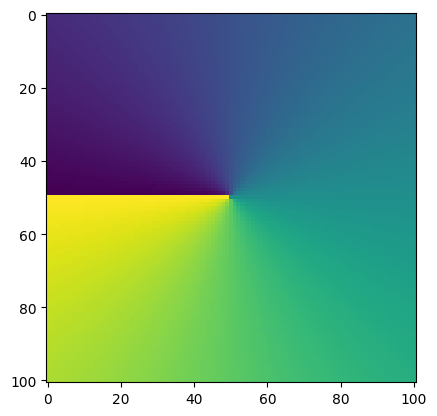

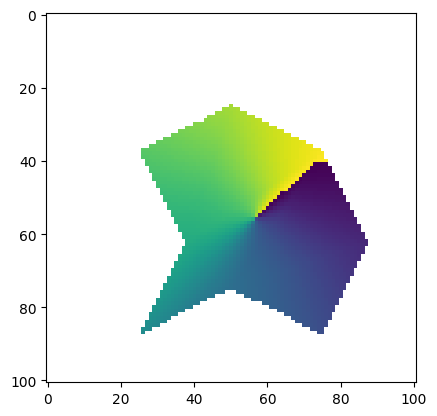

/tmp/ipykernel_44112/3639085874.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[i_row, 3].scatter(xi, yi, c=color, zorder=2)


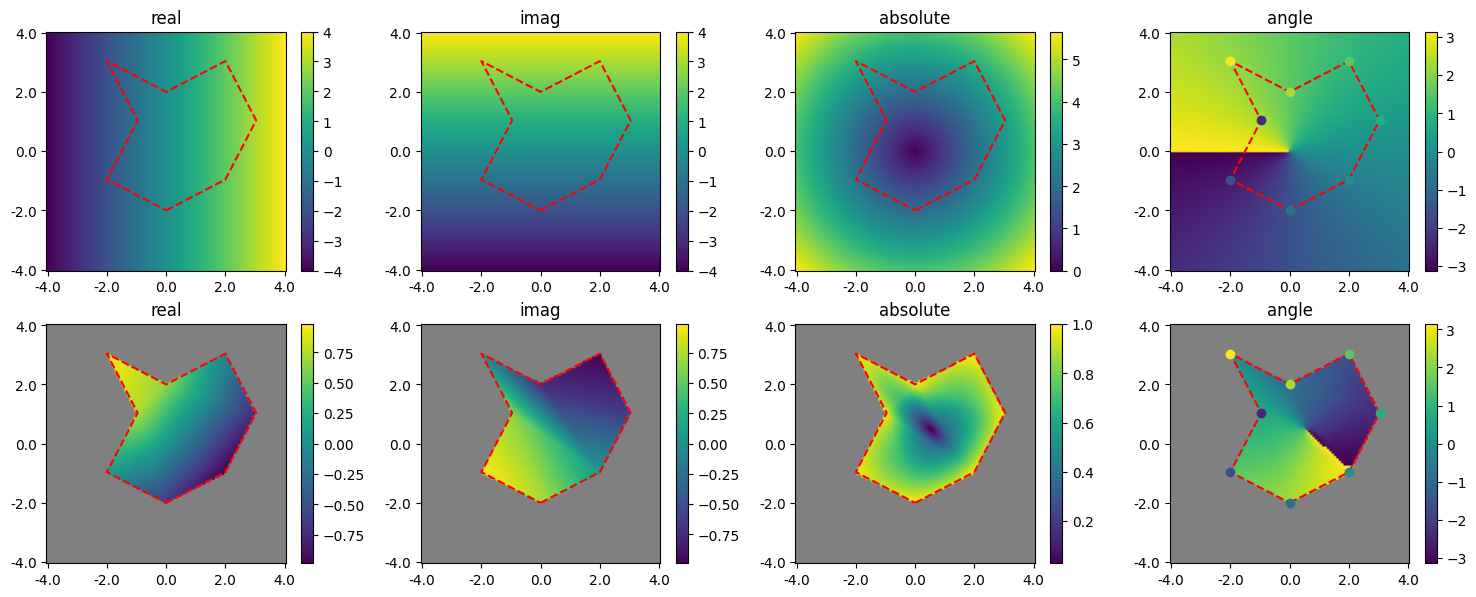

In [11]:
zs = np.array([-2j, 2-1j, 3+1j, 2+3j, 2j, -2+3j, -1+1j, -2-1j])
#zs = 3*np.exp(1j*2*np.pi*np.arange(8)/8)
angles = 2*np.pi*np.arange(len(zs))/len(zs) - 4
angles %= 2*np.pi

f1 = get_map_boundary_to_unit_circle(zs, angles=angles)


x = np.linspace(-4, 4, 101)
y = np.linspace(-4, 4, 101)

z0 = x.reshape(1, -1) + 1j*y.reshape(-1, 1)
plt.imshow(np.angle(z0))
plt.show()
z1 = f1(z0)
plt.imshow(np.angle(z1))
plt.show()

zx = np.append(zs, zs[0]).real
zy = np.append(zs, zs[0]).imag
zx = np.searchsorted(x, zx)
zy = np.searchsorted(y, zy)


fig, axs = plt.subplots(2, 4, figsize=(15, 6))
for (i_col, repr), (i_row, z) in itertools.product(enumerate([np.real, np.imag, np.abs, np.angle]), enumerate([z0, z1 ])):
    axs[i_row, i_col].set_title(f'{repr.__name__}')
    img = repr(z)
    cmap = plt.get_cmap().copy()
    cmap.set_bad(color='gray')
    sm = axs[i_row, i_col].imshow(img, cmap=cmap, origin='lower')
    plt.colorbar(sm, ax=axs[i_row, i_col])

    axs[i_row, i_col].plot(zx, zy, color='red', linestyle='--')
    axs[i_row, i_col].set_xticks(np.linspace(0, len(x)-1, 5).astype(int), x[np.linspace(0, len(x)-1, 5).astype(int)])
    axs[i_row, i_col].set_yticks(np.linspace(0, len(y)-1, 5).astype(int), y[np.linspace(0, len(y)-1, 5).astype(int)])
    #axs[i_row, i_col].grid(True)


for i_row in range(2):
    for i, (xi, yi, phi) in enumerate(zip(zx, zy, angles)):
        phi_val = 0.5 + 0.5*(phi - np.pi)/np.pi
        color = cmap(phi_val)
        axs[i_row, 3].scatter(xi, yi, c=color, zorder=2)

plt.tight_layout()
plt.show()

## Map from unit disk to unit disk changing the center
Now let's define $f_2:\mathbb{C}\to\mathbb{C}$, such that 
$$
    f_2(z_0) = 0, \; z_0 \in \{z\in\mathbb{C}: |z| < 1\}
$$
and 
$$
    f_2(e^{i\phi}) = e^{i\phi} \;\; \forall \phi\in[0, 2\pi)
$$
let's define the parameter $t$ such $t(z_0) = 0$ and $t(e^{t\phi}) = 1$:
$$
    t(z) = \frac{|z - z_0|}{|e^{i\cdot \arg(z - z_0)} - z_0|}
$$
then we can define $f_2(z)$:
$$
    f_2(z) = (1-t(z))\cdot (z - z_0) + t(z)\cdot z
$$
and additionally we can rotate the center for the angle $\alpha$:
$$
    f_2(z) = (1-t(z))\cdot(z - z_0)\cdot e^{i\alpha} + t(z)\cdot z
$$
This is better to choose the angle $\alpha$ same as angle in the closest border point 

In [12]:
def get_map_changing_center(z0, alpha=0):
    """
    """
    def f(z):
        z = np.asarray(z)
        t = np.abs(z - z0)/np.abs(np.exp(1j*np.angle(z - z0)) - z0)
        res = t*z + (1 - t)*(z - z0)*np.exp(1j*alpha)
        return res
    return f

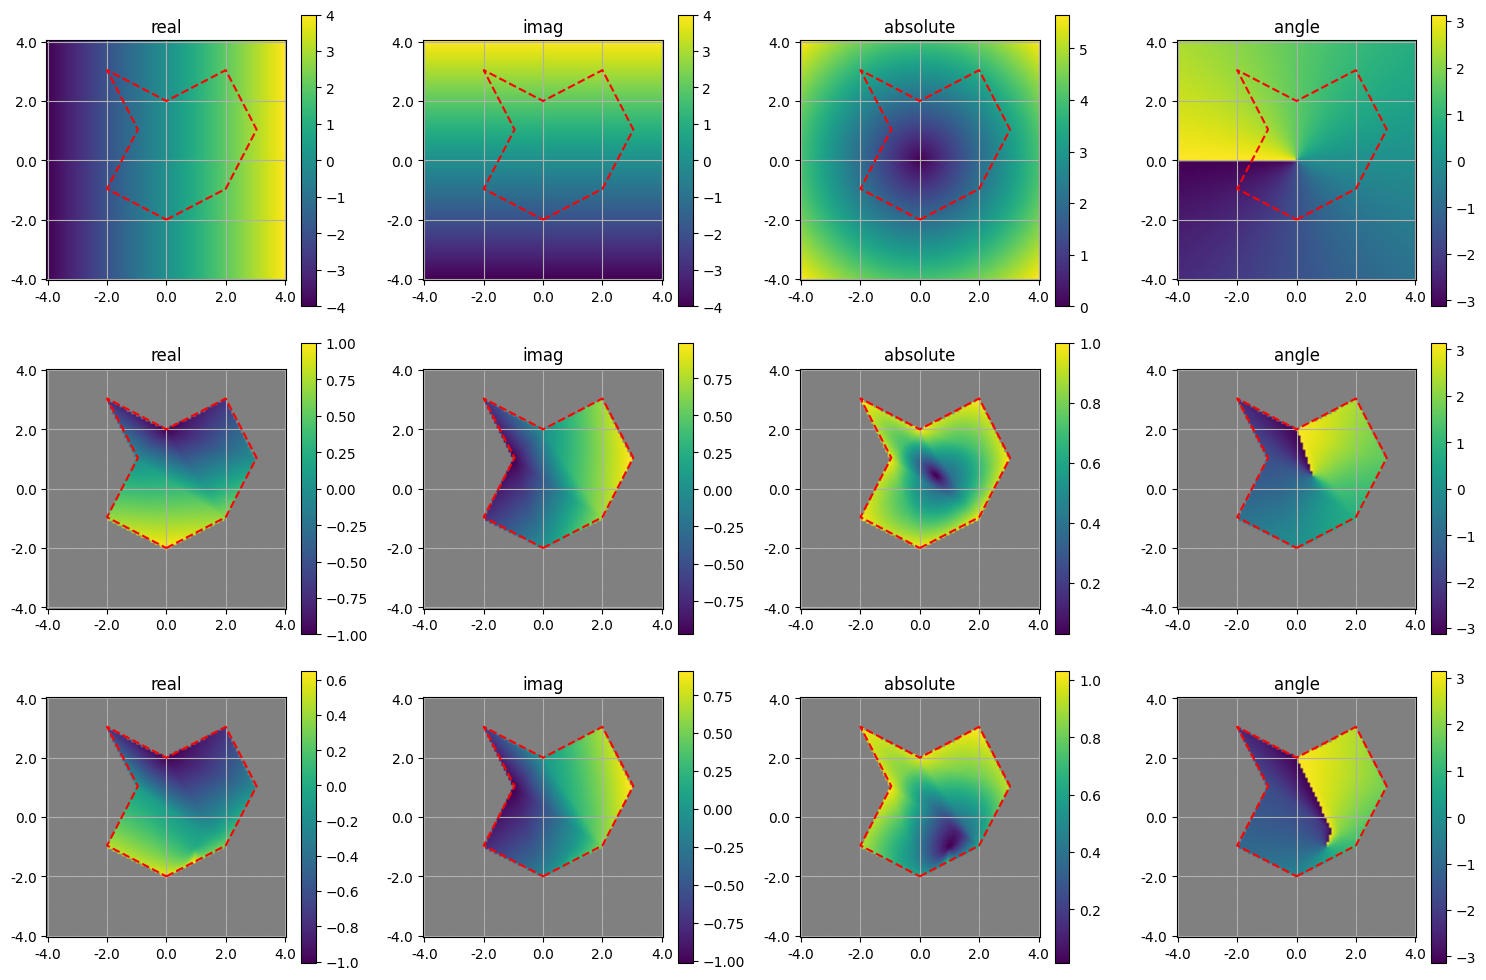

In [13]:
zs = np.array([-2j, 2-1j, 3+1j, 2+3j, 2j, -2+3j, -1+1j, -2-1j])
#zs = 3*np.exp(1j*2*np.pi*np.arange(8)/8)

z_center = 1 - 1j

f1 = get_map_boundary_to_unit_circle(zs)

z_center_updated = f1(z_center)
f2 = get_map_changing_center(z_center_updated)

x = np.linspace(-4, 4, 101)
y = np.linspace(-4, 4, 101)
z0 = x.reshape(1, -1) + 1j*y.reshape(-1, 1)
z1 = f1(z0)
z2 = f2(z1)

zx = np.append(zs, zs[0]).real
zy = np.append(zs, zs[0]).imag
zx = np.searchsorted(x, zx)
zy = np.searchsorted(y, zy)


fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for (i_col, repr), (i_row, z) in itertools.product(enumerate([np.real, np.imag, np.abs, np.angle]), enumerate([z0, z1, z2])):
    axs[i_row, i_col].set_title(f'{repr.__name__}')
    img = repr(z)
    cmap = plt.get_cmap().copy()
    cmap.set_bad(color='gray')
    sm = axs[i_row, i_col].imshow(img, cmap=cmap, origin='lower')
    plt.colorbar(sm, ax=axs[i_row, i_col])

    axs[i_row, i_col].plot(zx, zy, color='red', linestyle='--')
    axs[i_row, i_col].set_xticks(np.linspace(0, len(x)-1, 5).astype(int), x[np.linspace(0, len(x)-1, 5).astype(int)])
    axs[i_row, i_col].set_yticks(np.linspace(0, len(y)-1, 5).astype(int), y[np.linspace(0, len(y)-1, 5).astype(int)])
    axs[i_row, i_col].grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_44112/1966440554.py:13: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  mask = ndimage.zoom(mask, (8, 8), order=1, grid_mode=True).astype(bool).astype(int)


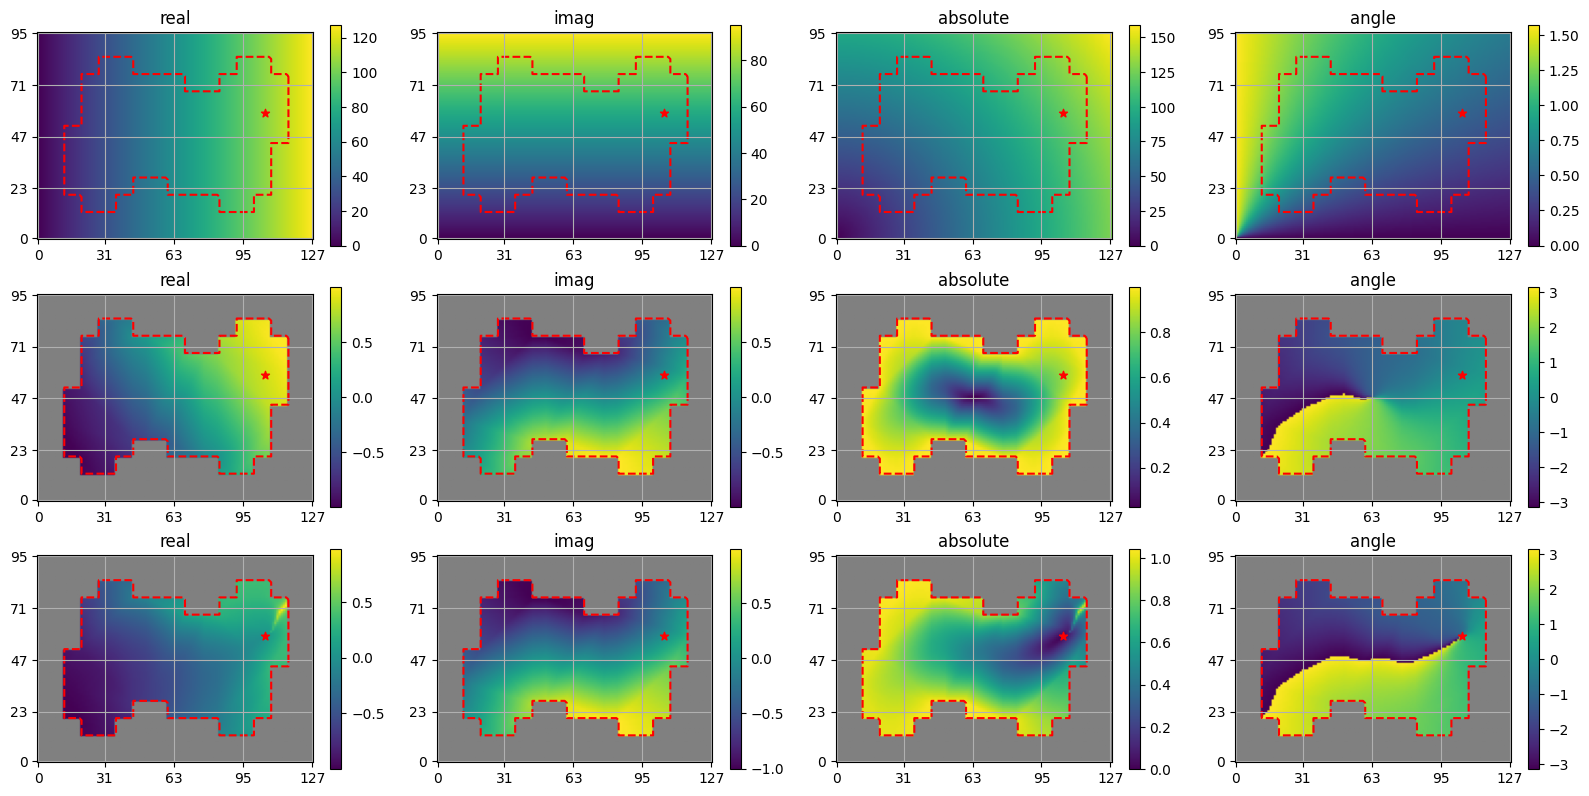

In [14]:
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1

#mask = ndimage.zoom(mask, (4, 4), order=1, grid_mode=True).astype(bool).astype(int)
mask = ndimage.zoom(mask, (8, 8), order=1, grid_mode=True).astype(bool).astype(int)


center_x, center_y = np.argwhere(mask)[np.random.randint(mask.sum())]

boundary = extract_ordered_boundary(mask, return_countor=True)
boundary_x, boundary_y = np.transpose(boundary)
boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi


zs = boundary_x + 1j*boundary_y
z_center = center_x + 1j*center_y

f1 = get_map_boundary_to_unit_circle(zs, angles=boundary_angles)

z_center_updated = f1(z_center)
f2 = get_map_changing_center(z_center_updated)


x = np.arange(mask.shape[0])
y = np.arange(mask.shape[1])
z0 = x.reshape(1, -1) + 1j*y.reshape(-1, 1)
z1 = f1(z0)
z2 = f2(z1)


zx = np.append(zs, zs[0]).real
zy = np.append(zs, zs[0]).imag
zx = np.searchsorted(x, zx)
zy = np.searchsorted(y, zy)

cmap = plt.get_cmap().copy()
cmap.set_bad(color='gray')

fig, axs = plt.subplots(3, 4, figsize=(16, 8))
for (i_col, repr), (i_row, z) in itertools.product(enumerate([np.real, np.imag, np.abs, np.angle]), enumerate([z0, z1, z2])):
    axs[i_row, i_col].set_title(f'{repr.__name__}')
    img = repr(z)
    
    sm = axs[i_row, i_col].imshow(img, cmap=cmap, origin='lower')
    plt.colorbar(sm, ax=axs[i_row, i_col])

    axs[i_row, i_col].plot(zx, zy, color='red', linestyle='--', zorder=1)
    axs[i_row, i_col].scatter(center_x, center_y, color='red', marker='*', zorder=2)
    axs[i_row, i_col].set_xticks(np.linspace(0, len(x)-1, 5).astype(int), x[np.linspace(0, len(x)-1, 5).astype(int)])
    axs[i_row, i_col].set_yticks(np.linspace(0, len(y)-1, 5).astype(int), y[np.linspace(0, len(y)-1, 5).astype(int)])
    axs[i_row, i_col].grid(True)



plt.tight_layout()
plt.show()

In [15]:
f = lambda z: f2(f1(z))
assert ((f(z0) == z2) | np.isnan(z2)).all()

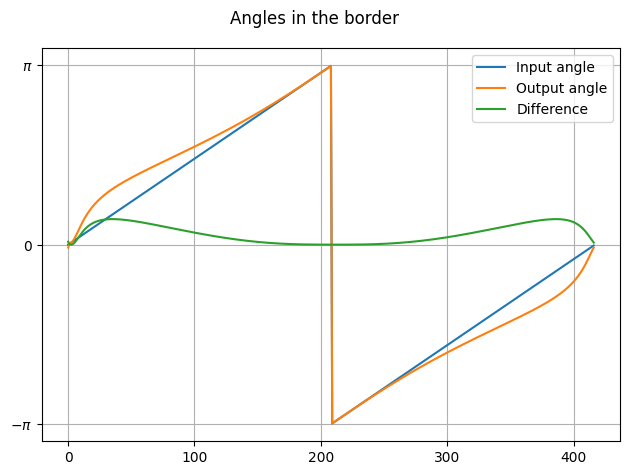

In [16]:
angles_given = boundary_angles
angles_given[angles_given > np.pi] -= 2*np.pi
angles_found = np.angle(f(zs))
difference = abs(angles_given - angles_found)
difference[difference > np.pi] = 2*np.pi - difference[difference > np.pi]

plt.suptitle('Angles in the border')
plt.plot(angles_given, label='Input angle')
plt.plot(angles_found, label='Output angle')
plt.plot(difference, label='Difference')
plt.legend()

plt.yticks([-np.pi, 0, np.pi],labels=[r'$-\pi$', '0', r'$\pi$'])

plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
assert False

AssertionError: 

# Combinatorial Way

In [ ]:
import networkx as nx
import pandas as pd

from tqdm import tqdm

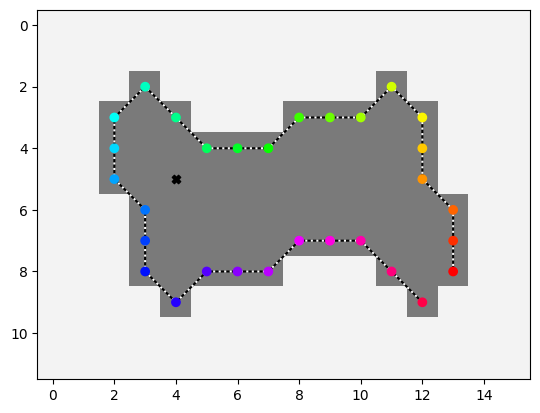

In [ ]:
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1


#mask = ndimage.zoom(mask, (1.5, 1.5), order=1, grid_mode=True).astype(bool).astype(int)
#mask = (ndimage.zoom(mask, (1.4, 1.6), order=1, grid_mode=True) >= 0.5).astype(int)
#mask = ndimage.zoom(mask, (2, 2), order=1, grid_mode=True).astype(bool).astype(int)
#mask = ndimage.zoom(mask, (3, 3), order=1, grid_mode=True).astype(bool).astype(int)
#mask = ndimage.zoom(mask, (4, 4), order=1, grid_mode=True).astype(bool).astype(int)

center_x, center_y = np.argwhere(mask)[np.random.randint(mask.sum())]

boundary = extract_ordered_boundary(mask, return_countor=False)
boundary_x, boundary_y = np.transpose(boundary)
boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi


fig, ax = plt.subplots(1, 1)
ax.imshow(np.transpose(mask), cmap='Greys', vmin=-0.2, vmax=1.8, zorder=0)

ax.plot(boundary_x, boundary_y, color='black', linestyle='-', zorder=1)
ax.plot(boundary_x, boundary_y, color='white', linestyle=':', zorder=1)
ax.scatter(boundary_x, boundary_y, c=plt.get_cmap('hsv')(boundary_angles/(2*np.pi)), zorder=2)

ax.scatter(center_x, center_y, color='black', marker='X', zorder=3)
plt.show()

In [ ]:
def get_graph_from_mask(mask) -> nx.Graph:
    """

    """
    mask = mask.astype(bool)
    edges_v = np.argwhere(mask[1:, :] & mask[:-1, :])
    edges_v = np.array([edges_v, edges_v + np.array([1, 0])])
    edges_v = edges_v.transpose((1, 0, 2))
    edges_v = [(tuple(node0), tuple(node1)) for node0, node1 in edges_v]

    edges_h = np.argwhere(mask[:, 1:] & mask[:, :-1])
    edges_h = np.array([edges_h, edges_h + np.array([0, 1])])
    edges_h = edges_h.transpose((1, 0, 2))
    edges_h = [(tuple(node0), tuple(node1)) for node0, node1 in edges_h]

    nodes = [tuple(node) for node in np.argwhere(mask)]

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges_h + edges_v)
    return g

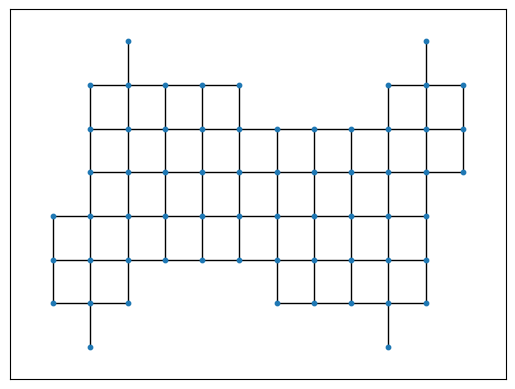

In [ ]:
g = get_graph_from_mask(mask)
pos = {node: node for node in g.nodes}

nx.draw_networkx(g, pos=pos, with_labels=False, node_size=10)

In [ ]:
def get_distance_from_nodes(g: nx.Graph, nodes, path_lens=None):
    """
    """
    if path_lens is None:
        path_lens = np.zeros(len(nodes), dtype=int)
    
    if len(nodes) == len(g.nodes):
        return nodes, path_lens

    max_path_len = np.max(path_lens)
    previous_nodes = [node for node, path_len in zip(nodes, path_lens) if path_len == max_path_len]
    next_nodes = []
    for previous_node in previous_nodes:
        next_nodes += list(g.neighbors(previous_node))
    next_nodes = list(set(next_nodes) - set(nodes))
    if len(next_nodes) == 0:
        return nodes, path_lens
    
    nodes = nodes + next_nodes
    path_lens = np.concatenate([path_lens, (max_path_len + 1)*np.ones(len(next_nodes), dtype=int)])
    return get_distance_from_nodes(g, nodes, path_lens)

In [ ]:
def get_radius_map(g, center, boundary):
    """
    """
    nodes_b, paths_b = get_distance_from_nodes(g, boundary)
    paths_b = pd.Series(paths_b, index=nodes_b).sort_index()
    nodes_c, paths_c = get_distance_from_nodes(g, [center])
    paths_c = pd.Series(paths_c, index=nodes_c).sort_index()
    r_map = paths_c/(paths_b + paths_c)
    r_map = r_map.fillna(0)
    return r_map

In [ ]:
from scipy.stats import gmean

def get_angle_map(g, center, boundary, boundary_angles=None):
    """
    """
    # this realisation works only with small graphs, otherwise fail cause of memory
    if boundary_angles is None:
        boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi

    df = pd.DataFrame({'boundary_node': boundary, 'boundary_angle': boundary_angles})
    tqdm.pandas()
    df['node'] = df['boundary_node'].progress_apply(lambda boundary_node: list(nx.all_shortest_paths(g, center, boundary_node)))

    df['angle'] = np.exp(1j*df['boundary_angle'])
    df = df.explode('node').explode('node')
    
    a_map = df.groupby('node')['angle'].agg(gmean).apply(lambda x: np.angle(x)%(2*np.pi))
    a_map.loc[boundary] = boundary_angles
    return a_map


In [ ]:
def get_angle_map(g, center, boundary, boundary_angles=None):
    """
    """
    # and this one just does not work correctly by some reason
    if boundary_angles is None:
        boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi
    
    counts = pd.Series(0, index=g.nodes)
    angles_cos = pd.Series(0, index=g.nodes)
    angles_sin = pd.Series(0, index=g.nodes)
    for boundary_node, boundary_angle in tqdm(zip(boundary, boundary_angles), total=len(boundary)):
        for path in nx.all_shortest_paths(g, center, boundary_node):
            path_unbordered = [node for node in path if (node in [center, boundary_node]) or (node not in boundary)]
            counts.loc[path_unbordered] += 1
            angles_cos.loc[path_unbordered] += np.cos(boundary_angle)
            angles_sin.loc[path_unbordered] += np.sin(boundary_angle)
    angles_cos /= counts
    angles_sin /= counts
    
    a_map = pd.Series({node: np.atan2(angles_sin[node], angles_cos[node]) for node in g.nodes}) % (2*np.pi)

    return a_map

  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]/tmp/ipykernel_16773/514884530.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[135.9781476  27.9781476   3.9781476   9.9781476  18.9781476  30.9781476
 108.9781476  90.9781476   0.9781476]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  angles_cos.loc[path_unbordered] += np.cos(boundary_angle)
/tmp/ipykernel_16773/514884530.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.20791169 0.20791169 0.20791169 0.20791169 0.20791169 0.20791169
 0.20791169 0.20791169 0.20791169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  angles_sin.loc[path_unbordered] += np.sin(boundary_angle)
100%|██████████| 30/30 [00:04<00:00,  7.29it/s]


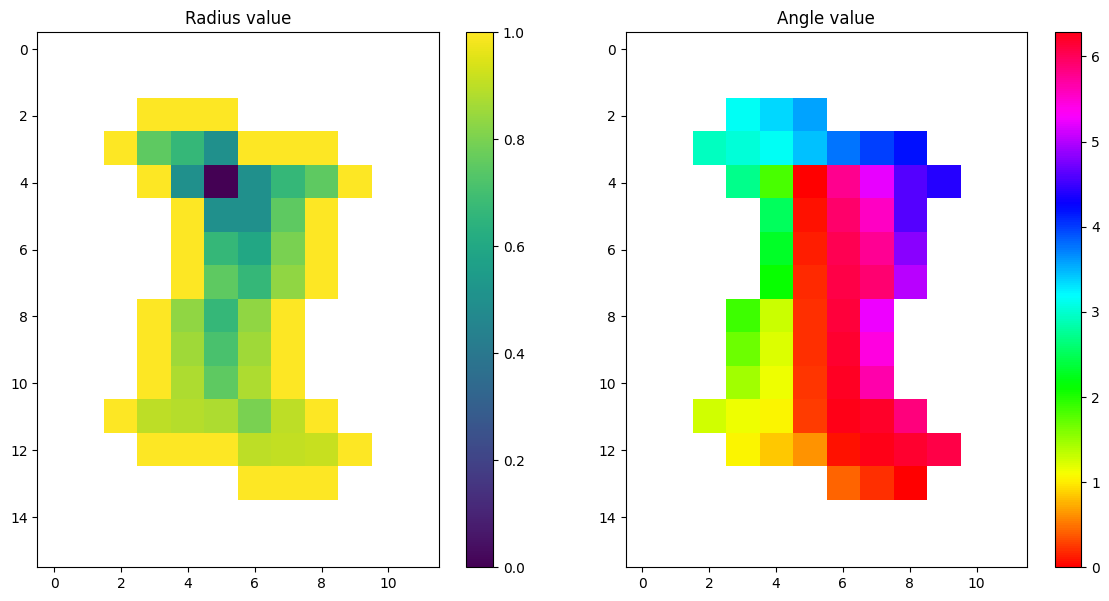

In [ ]:
r_map = get_radius_map(g, (center_x, center_y), boundary)
a_map = get_angle_map(g, (center_x, center_y), boundary)

r_map_img = np.nan*mask
for (x, y), value in r_map.items():
    r_map_img[x, y] = value

a_map_img = np.nan*mask
for (x, y), value in a_map.items():
    a_map_img[x, y] = value
    

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Radius value')
axs[1].set_title('Angle value')
sm0 = axs[0].imshow(r_map_img, cmap='viridis')
sm1 = axs[1].imshow(a_map_img, cmap='hsv')
plt.colorbar(sm0, ax=axs[0])
plt.colorbar(sm1, ax=axs[1])

plt.tight_layout()
plt.show()